In [2]:
import numpy as np
import astropy.io.ascii as ascii
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import csv

Define Functions Used

In [3]:
#Rodrigo Nemmen's function for calculating reduced X2 data
#We need to provide an sd argument :c
def redchisqg(ydata,ymod,deg=2,sd=None):
    
      """  
 Returns the reduced chi-square error statistic for an arbitrary model,   
 chisq/nu, where nu is the number of degrees of freedom. If individual   
 standard deviations (array sd) are supplied, then the chi-square error   
 statistic is computed as the sum of squared errors divided by the standard   
 deviations. See http://en.wikipedia.org/wiki/Goodness_of_fit for reference.  
   
 ydata,ymod,sd assumed to be Numpy arrays. deg integer.  
   
 Usage:  
 >>> chisq=redchisqg(ydata,ymod,n,sd)  
 where  
  ydata : data  
  ymod : model evaluated at the same x points as ydata  
  n : number of free parameters in the model  
  sd : uncertainties in ydata  
   
 Rodrigo Nemmen  
 http://goo.gl/8S1Oo  
       """
        
      # Chi-square statistic  
      if sd==None:  
           chisq=np.sum((ydata-ymod)**2)  
      else:  
           chisq=np.sum( ((ydata-ymod)/sd)**2 )  
             
      # Number of degrees of freedom assuming 2 free parameters  
      nu=ydata.size-1-deg  
        
      return chisq/nu      

In [4]:
#Functions for calculating distance
def y_dist(y1, y2):
    return np.abs(y2 - y1)
def x_dist(x1, x2):
    return np.abs(x2 - x1)
def t_dist(x_dist, y_dist):
    return np.sqrt((x_dist)**2 + (y_dist)**2)

Provide Necessary Data

In [5]:
#Insert path and filename for the isochrone data (.dat)
isochrone_path = "../"
isochrone_filename = "iso_hst_stmag_z070a.dat"
data = ascii.read(isochrone_path + isochrone_filename)

#Insert path and filename for data (.csv)
data_path = ""
data_filename = "Sorted_M29B.csv"
file = open('Sorted_M29B.csv')
csvreader = csv.reader(file)
header = next(csvreader)

Plot The Isochrone

In [6]:
#Create a list of the different ages (log scale) used in the isochrone data
log_age = np.unique(data['col1'])

#for i in range(len(log_age)):
 #   locals()['M_V_' + str(i)] = []
  #  locals()['M_B_' + str(i)]  = []

#Create a list of indices that correspond to the different ages
for i in range(len(log_age)):
    locals()['log_age_index_' + str(i)] = np.array(np.where(data['col1'] == log_age[i])).flatten()

#Create a list of the Blue and Visible filter Magnitudes for each isochrone age
for i in range(len(log_age)):
    locals()['M_B_' + str(i)] = data['col9'][locals()['log_age_index_' + str(i)]]
    locals()['M_V_' + str(i)] = data['col10'][locals()['log_age_index_' + str(i)]]

#Create a list of the B - V magnitudes for each isochrone age
for i in range(len(log_age)):
    locals()['M_BV_' + str(i)] = np.array(locals()['M_B_' + str(i)]) - np.array(locals()['M_V_' + str(i)])

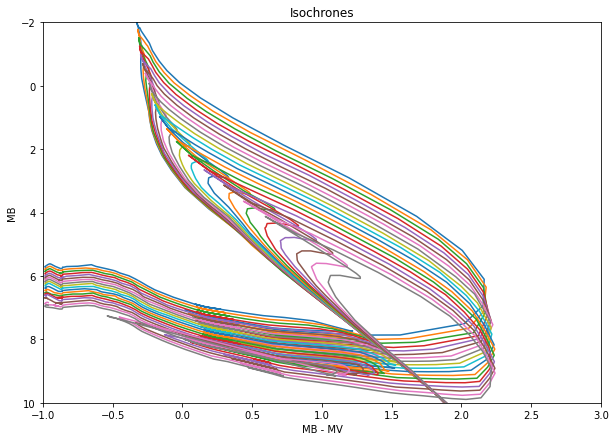

In [7]:
#Plot The Isochrones!
#Insert x and y Limits that correspond with the observed data you are fitting to (to zoom in on relevant part of isochrone)
x_lower_lim = -1
x_upper_lim = 3
y_lower_lim = -2
y_upper_lim = 10
#Use trial and error to cull out Isochrone ages that graph beyond the limits or do not visibly match the observed data
isochrone_lower = 24
isochrone_upper = 43

#Generate and save
plt.figure(figsize = (10, 7))
for i in range(isochrone_upper):
    if i > isochrone_lower:
        plt.plot(locals()['M_BV_' + str(i)], locals()['M_B_' + str(i)])
plt.gca().invert_yaxis()
plt.title("Isochrones")
plt.xlabel('MB - MV')
plt.ylabel('MB')
plt.xlim(x_lower_lim, x_upper_lim)
plt.ylim(y_upper_lim, y_lower_lim)
plt.savefig(isochrone_filename[:-4] + "-HR.png")

In [8]:
#returns the index that corresponds with a given log age
isochrone_age = 7.3

print(np.array(np.where(log_age == isochrone_age)).flatten()[0])

6


(10.0, -2.0)

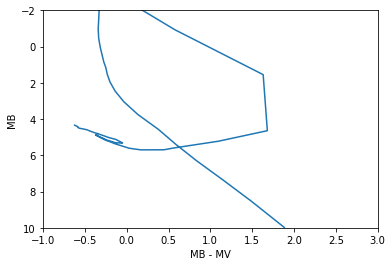

In [9]:
#plots an individual isochrone given an index
isochrone_index_1 = 10

plt.plot(locals()['M_BV_' + str(isochrone_index_1)], locals()['M_B_' + str(isochrone_index_1)])
plt.gca().invert_yaxis()
plt.xlabel('MB - MV')
plt.ylabel('MB')
plt.xlim(x_lower_lim, x_upper_lim)
plt.ylim(y_upper_lim, y_lower_lim)

Read In and Graph Observed Data

In [10]:
brows = np.loadtxt('mag_M29B.txt')
vrows = np.loadtxt('mag_M29V.txt')
bsig = np.loadtxt("Final_M29Blue.fits_error.txt")
vsig = np.loadtxt("Final_M29Visible.fits_error.txt")
b_x = []
v_x = []
b_y = []
v_y = []
b_m = []
v_m = []
mb_mv = []
bsigma = []
vsigma = []
bvsigma = []
pc = 1161

count = 0 
for i in range(len(brows)):
    for j in range(len(vrows)):        
            if (abs(brows[i][1] - vrows[j][1]) + abs(brows[i][2] - vrows[j][2]))**.5 < 3:
                count = count + 1
                b_x.append(brows[i][1])
                v_x.append(vrows[j][1])
                b_y.append(brows[i][2])
                v_y.append(vrows[j][2])
                b_m.append(brows[i][0] - 5*np.log10(pc) + 5)
                v_m.append(vrows[j][0])
                mb_mv.append((brows[i][0] - 5*np.log10(pc) + 5) - (vrows[j][0] - 5*np.log10(pc) + 5))
                bsigma.append(bsig[i])     
                vsigma.append(vsig[j])
                if np.abs((bsig[i]/b_m[-1]) - (vsig[j]/v_m[-1])) < .25:
                    bvsigma.append(np.abs((bsig[i]/b_m[-1]) - (vsig[j]/v_m[-1])))
                else:
                    bvsigma.append(.25)
print(count)
print(np.shape(v_m))
print(np.shape(mb_mv))

60
(60,)
(60,)


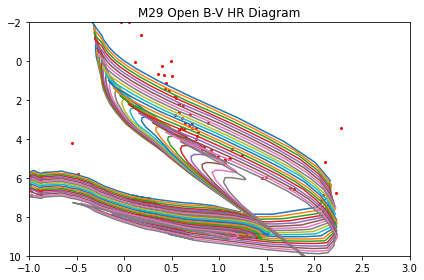

In [11]:
#Genaro's code for plotting the observed data, along with plotting the culled isochrone data ontop
graph, (plot1) = plt.subplots(1)

plot1.plot(mb_mv, b_m, 'ro', ms = 2)
for i in range(isochrone_upper):
    if i > isochrone_lower:
        plot1.plot(locals()['M_BV_' + str(i)], locals()['M_B_' + str(i)][::])
plot1.set_title("M29 Open B-V HR Diagram")
plot1.invert_yaxis()
plt.xlim(x_lower_lim, x_upper_lim)
plt.ylim(y_upper_lim, y_lower_lim)
graph.tight_layout()
plt.show()
# plt.savefig('HR M29.png')

Chi-Squared

In [12]:
#Finds the indices that correlate with the closest isochrone data point for each point in the observed data
for k in range(isochrone_upper):
    if (k > isochrone_lower):
        temp_index = [0] * len(locals()['M_BV_' + str(k)])
        locals()['closest_index_' + str(k)] = [0] * len(b_m)
        for i in range(len(b_m)):
            for j in range(len(locals()['M_BV_' + str(k)])):
                temp_index[j]  = (t_dist(x_dist(b_m[i],locals()['M_B_' + str(k)][j]), y_dist(mb_mv[i], locals()['M_BV_' + str(k)][j])))
            locals()['closest_index_' + str(k)][i] = np.array((np.where(temp_index == np.min(temp_index)))).flatten()[0]

In [13]:
x2_values = []
print('Index        X2')
for k in range(isochrone_upper):
    if (k > isochrone_lower):
        print(str(k) + "     " + str(redchisqg(np.array(mb_mv), locals()['M_BV_' + str(k)][locals()['closest_index_' + str(k)]])))
        x2_values.append(redchisqg(np.array(mb_mv), locals()['M_BV_' + str(k)][locals()['closest_index_' + str(k)]]))
lowest_X2 = np.array((np.where(x2_values == np.min(x2_values)))).flatten()[0]
lowest_X2_index = lowest_X2 + isochrone_lower + 1
print("The index corresponding to the lowest X2 Value is: " + str(lowest_X2_index))

Index        X2
25     0.19113373298896721
26     0.2020375269601585
27     0.1710309752238553
28     0.16632763443999607
29     0.1764995195732306
30     0.1577173923214689
31     0.1614676281356104
32     0.1565485562508679
33     0.14191788965978222
34     0.16500364404367626
35     0.14670030856660787
36     0.14007461944368702
37     0.12851063397686696
38     0.13657610036979098
39     0.11753009639596823
40     0.11331444217219903
41     0.12589597135304897
42     0.14003586890636155
The index corresponding to the lowest X2 Value is: 40


reduced Xi square: 0.11331444217219903
Isochrone Log Age: 9.0


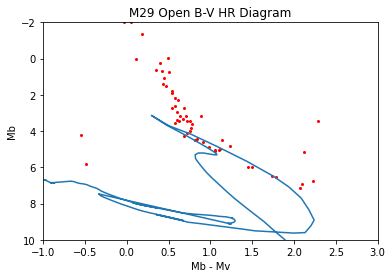

In [28]:
#Graph the best fit isochrone (lowest Chi Square) to with the data
plt.figure()
plt.xlabel("Mb - Mv")
plt.ylabel("Mb")
plt.xlim(x_lower_lim, x_upper_lim)
plt.ylim(y_upper_lim, y_lower_lim)
plt.plot(mb_mv, b_m, 'ro', ms = 2)
plt.plot(locals()['M_BV_' + str(lowest_X2_index)], locals()['M_B_' + str(lowest_X2_index)])
plt.title("M29 Open B-V HR Diagram")
print("reduced Xi square: " + str(x2_values[lowest_X2]))
print("Isochrone Log Age: " + str(log_age[lowest_X2_index]))
plt.savefig("finalHR.png")